In [25]:
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
from datasets import concatenate_datasets, load_dataset
import seaborn as sns

In [15]:
def prepare_NoOp(data_path, split, all_subs, noOps='text'):
    print(f"Loading MMMU dataset from {data_path} for split={split} ...")
    sub_dataset_list = [load_noop(data_path, subject, split=split, noOps=noOps) for subject in tqdm(all_subs)]
    dataset = concatenate_datasets(sub_dataset_list)
    print("NoOp Dataset loaded:", dataset)
    return dataset

def prepare_dataset(data_path, split, all_subs):
    print(f"Loading MMMU dataset from {data_path} for split={split} ...")
    sub_dataset_list = [load_dataset(data_path, subject, split=split) for subject in tqdm(all_subs)]
    dataset = concatenate_datasets(sub_dataset_list)
    print("Dataset loaded:", dataset)
    return dataset

def get_dataset(noop='all'):
    all_subs = [
    'Accounting', 'Agriculture', 'Architecture_and_Engineering', 'Art',
    'Art_Theory','Basic_Medical_Science','Biology','Chemistry','Clinical_Medicine',
    'Computer_Science','Design','Diagnostics_and_Laboratory_Medicine','Economics',
    'Electronics','Energy_and_Power','Finance','Geography','History','Literature',
    'Manage','Marketing','Materials','Math','Mechanical_Engineering','Music',
    'Pharmacy','Physics','Psychology','Public_Health','Sociology'
    ]
    # all_subs = ['Accounting', 'Art']
    data_path = "MMMU/MMMU"
    split = "validation"
    subs = all_subs
    if noop != "none":
        dataset = prepare_NoOp(data_path, split, subs, noop)
    else:
        dataset = prepare_dataset(data_path, split, subs)
    return dataset

In [16]:
dset = get_dataset('none')

Loading MMMU dataset from MMMU/MMMU for split=validation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Dataset loaded: Dataset({
    features: ['id', 'question', 'options', 'explanation', 'image_1', 'image_2', 'image_3', 'image_4', 'image_5', 'image_6', 'image_7', 'img_type', 'answer', 'topic_difficulty', 'question_type', 'subfield'],
    num_rows: 900
})


In [37]:
result_root = "/jet/home/billyli/mmmu_NoOps/mmmu/sbatch_results_attn_2/attention_scores"
files = os.listdir(result_root)
answer_data = "/jet/home/billyli/mmmu_NoOps/mmmu/val.json"
with open(answer_data, 'r') as f:
    answers = json.load(f)

In [ ]:
id_map = {el['id']: el for el in dset}
for key in id_map.keys():
    id_map[key]['prediction'] = answers[key]

In [49]:
all_img_c = torch.zeros(28,28)
all_noop_c = torch.zeros(28,28)
all_txt_c = torch.zeros(28,28)

all_img_w = torch.zeros(28,28)
all_noop_w = torch.zeros(28,28)
all_txt_w = torch.zeros(28,28)

for file in files:
    fid = file.split(".")[0]
    sample = id_map[fid]
    attn = torch.load(os.path.join(result_root, file))
    img_attn = attn[:, 0, :]
    noop_attn = attn[:, 1, :]
    text_attn = attn[:, 2, :]
    if sample['prediction'] == sample['answer']:
        all_img_c += img_attn
        all_noop_c += noop_attn
        all_txt_c += text_attn
    else:
        all_img_w += img_attn
        all_noop_w += noop_attn
        all_txt_w += text_attn
        
img_diff = all_img_w - all_img_c
noop_diff = all_noop_w - all_noop_c
txt_diff = all_txt_w - all_txt_c

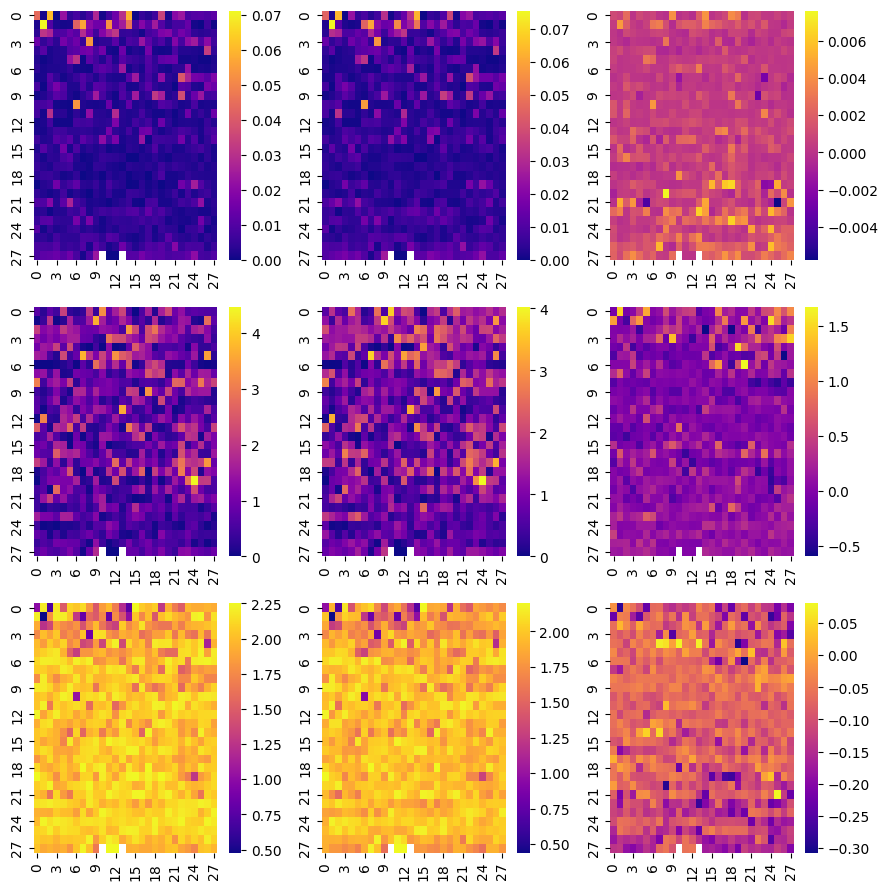

In [68]:

fig, axs = plt.subplots(3, 3, figsize=(9, 9))
all_diff = [img_diff, noop_diff, txt_diff]
all_wrong = [all_img_w, all_noop_w, all_txt_w]
all_corr = [all_img_c, all_noop_c, all_txt_c]

# Convert tensors to numpy arrays
data_np = [d.cpu().numpy() for d in data]

# Compute global min and max for consistent color scale
vmin = min(d.min() for d in data_np)
vmax = max(d.max() for d in data_np)

# Plot heatmaps with shared color scale
for i in range(3):
    sns.heatmap(all_corr[i], cmap="plasma", ax=axs[i, 0])
    sns.heatmap(all_wrong[i], cmap="plasma",  ax=axs[i, 1])
    sns.heatmap(all_diff[i], cmap="plasma", ax=axs[i, 2])

plt.tight_layout()
plt.show()


<Axes: >

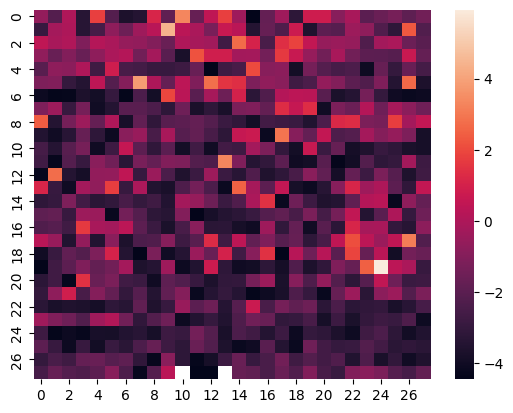

In [70]:
txt_noop_diff = (all_noop_w + all_noop_c) - (all_txt_w + all_txt_c)
sns.heatmap(txt_noop_diff)